In [2]:
# Import and Setup

In [3]:
import sys, pandas as pd
print(sys.version)
print("pandas:", pd.__version__)

3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]
pandas: 2.3.3


In [4]:
%pip -q install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Download CPI from FRED and standardize the column name
import pandas_datareader.data as web
import pandas as pd

SERIES = "CPIAUCSL"          # CPI for All Urban Consumers (monthly)
START  = "1990-01-01"

df = web.DataReader(SERIES, "fred", START).dropna()
df = df.rename(columns={SERIES: "y"})
df.head(), df.tail(), df.shape

(                y
 DATE             
 1990-01-01  127.5
 1990-02-01  128.0
 1990-03-01  128.6
 1990-04-01  128.9
 1990-05-01  129.1,
                   y
 DATE               
 2025-07-01  322.132
 2025-08-01  323.364
 2025-09-01  324.368
 2025-11-01  325.031
 2025-12-01  326.030,
 (431, 1))

In [6]:
#Force a clean monthly index and fill any gaps
df = df.asfreq("MS")
df["y"] = df["y"].ffill()

TEST_PERIODS = 24
train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("df freq:", df.index.freqstr)
print("train last:", train.index.max(), "test first:", test.index.min())
print("Any NaNs in df?", df["y"].isna().any())

df freq: MS
train last: 2023-12-01 00:00:00 test first: 2024-01-01 00:00:00
Any NaNs in df? False


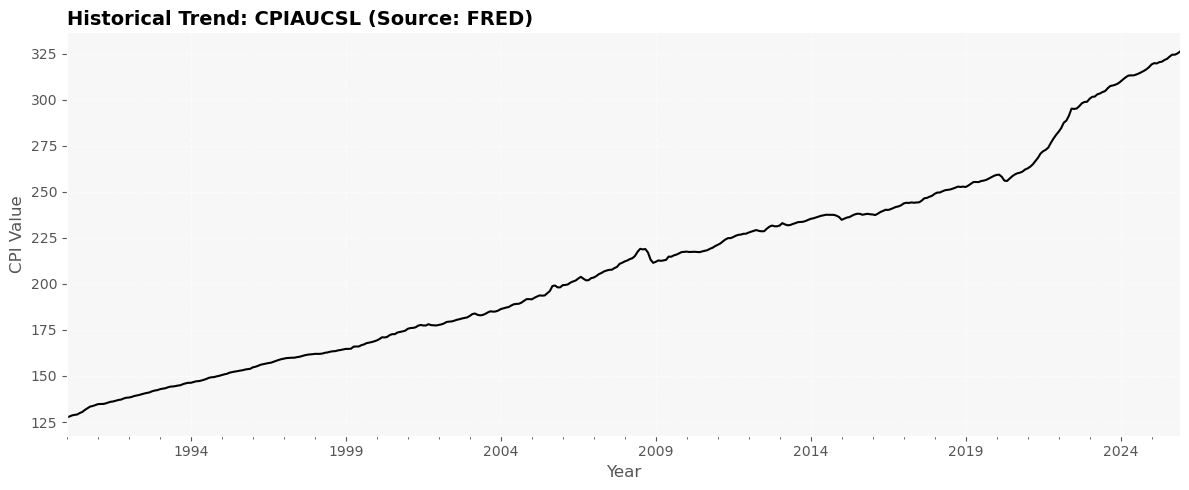

In [7]:
# Quick Plot
import matplotlib.pyplot as plt

plt.style.use('ggplot')
ax = df["y"].plot(figsize=(12, 5), color="black", linewidth=1.5)

ax.set_title(f"Historical Trend: {SERIES} (Source: FRED)", fontweight='bold', loc='left', fontsize=14)
ax.set(xlabel="Year", ylabel="CPI Value", facecolor='#f7f7f7')
ax.grid(True, linestyle='--', alpha=0.5)

for s in ["top", "right"]: ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# Time-based train/test split i.e. last 24 months
import numpy as np

TEST_PERIODS = 24

train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("Train:", train.index.min().date(), "->", train.index.max().date(), "rows:", len(train))
print("Test :", test.index.min().date(),  "->", test.index.max().date(),  "rows:", len(test))

Train: 1990-01-01 -> 2023-12-01 rows: 408
Test : 2024-01-01 -> 2025-12-01 rows: 24


In [7]:
# ARIMA

In [8]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [16]:
# Fit ARIMA on Training Data
model = ARIMA(train["y"], order=(1,1,1))
arima_fit = model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  408
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -348.637
Date:                Fri, 23 Jan 2026   AIC                            703.274
Time:                        00:39:34   BIC                            715.300
Sample:                    01-01-1990   HQIC                           708.033
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6539      0.033     19.737      0.000       0.589       0.719
ma.L1          0.0384      0.048      0.806      0.420      -0.055       0.132
sigma2         0.3243      0.014     23.077      0.0

In [17]:
# Forecast Test Period
forecast = arima_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)
forecast.head()

DATE
2024-01-01    309.172287
2024-02-01    309.458215
2024-03-01    309.645174
2024-04-01    309.767420
2024-05-01    309.847353
Freq: MS, Name: predicted_mean, dtype: float64

In [18]:
# Evaluate Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred, label="model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE : {mae:.3f}")
    print(f"{label} RMSE: {rmse:.3f}")
    return mae, rmse

fc = arima_fit.get_forecast(steps=len(test))
forecast = fc.predicted_mean
forecast.index = test.index

arima_mae, arima_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    forecast.to_numpy(),
    label="ARIMA(1,1,1)"
)

ARIMA(1,1,1) MAE : 8.040
ARIMA(1,1,1) RMSE: 9.286


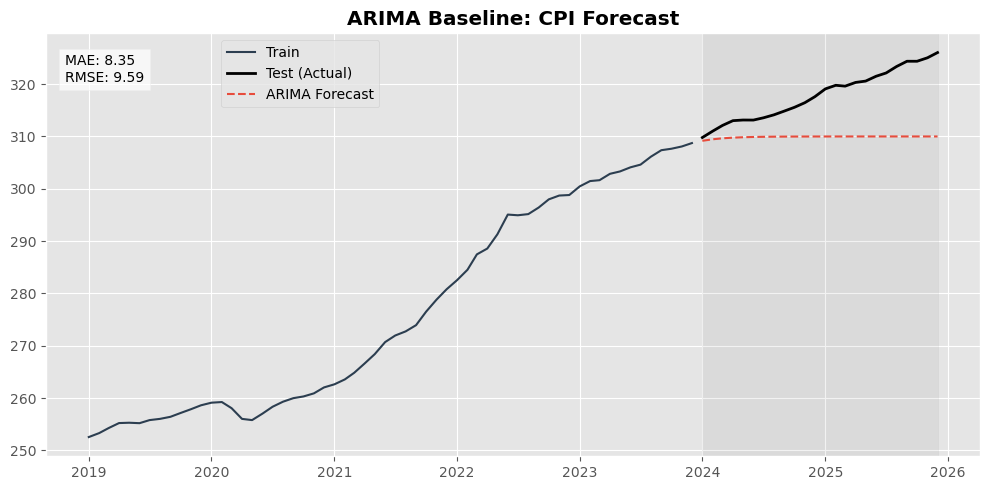

In [19]:
# Plot: train vs test vs forecast
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot data (Zoomed to last 5 years of training for clarity)
ax.plot(train.index[-60:], train["y"][-60:], label="Train", color="#2c3e50")
ax.plot(test.index, test["y"], label="Test (Actual)", color="black", linewidth=2)
ax.plot(forecast.index, forecast, label="ARIMA Forecast", color="#e74c3c", linestyle="--")

# Highlights & Text
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1)
ax.text(0.02, 0.95, "MAE: 8.35\nRMSE: 9.59", transform=ax.transAxes, 
        va='top', bbox=dict(facecolor='white', alpha=0.7))

# Legend & Title
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0)) # Offset to avoid text box
ax.set_title("ARIMA Baseline: CPI Forecast", fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
# Create comparative results table
results = pd.DataFrame(columns=[
    "model",
    "mae",
    "rmse",
    "train_end",
    "test_start",
    "test_end"
])

results

,model,mae,rmse,train_end,test_start,test_end


In [21]:
# Add ARIMA Results
results.loc[len(results)] = [
    "ARIMA(1,1,1)",
    float(arima_mae),
    float(arima_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]

results

,model,mae,rmse,train_end,test_start,test_end
0,"ARIMA(1,1,1)",8.040418,9.28629,2023-12-01,2024-01-01,2025-12-01


In [22]:
## Prophet

In [23]:
%pip -q install prophet

Note: you may need to restart the kernel to use updated packages.


In [24]:
from prophet import Prophet

In [25]:
# Prepare data in prophet format
prophet_df = df.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_train = train.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_test  = test.reset_index().rename(columns={"DATE": "ds", "y": "y"})

prophet_train.head(), prophet_test.head()

(          ds      y
 0 1990-01-01  127.5
 1 1990-02-01  128.0
 2 1990-03-01  128.6
 3 1990-04-01  128.9
 4 1990-05-01  129.1,
           ds        y
 0 2024-01-01  309.794
 1 2024-02-01  311.022
 2 2024-03-01  312.107
 3 2024-04-01  313.016
 4 2024-05-01  313.140)

In [26]:
# Fit prophet
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(prophet_train)

00:39:55 - cmdstanpy - INFO - Chain [1] start processing
00:39:55 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Forcast Test Dates
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"]
prophet_forecast.index = pd.to_datetime(prophet_forecast.index)

prophet_forecast.head(), prophet_forecast.tail()

(ds
 2024-01-01    301.606843
 2024-02-01    302.260264
 2024-03-01    303.389609
 2024-04-01    303.945910
 2024-05-01    304.732996
 Name: yhat, dtype: float64,
 ds
 2025-08-01    316.830037
 2025-09-01    317.788447
 2025-10-01    318.491353
 2025-11-01    319.003358
 2025-12-01    319.639302
 Name: yhat, dtype: float64)

In [28]:
# Evaluate
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"]
prophet_forecast.index = pd.to_datetime(prophet_forecast.index)

prophet_forecast.head(), prophet_forecast.tail()

prophet_mae, prophet_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    prophet_forecast.reindex(test.index).to_numpy(),
    label="Prophet"
)

Prophet MAE : 7.089
Prophet RMSE: 7.150


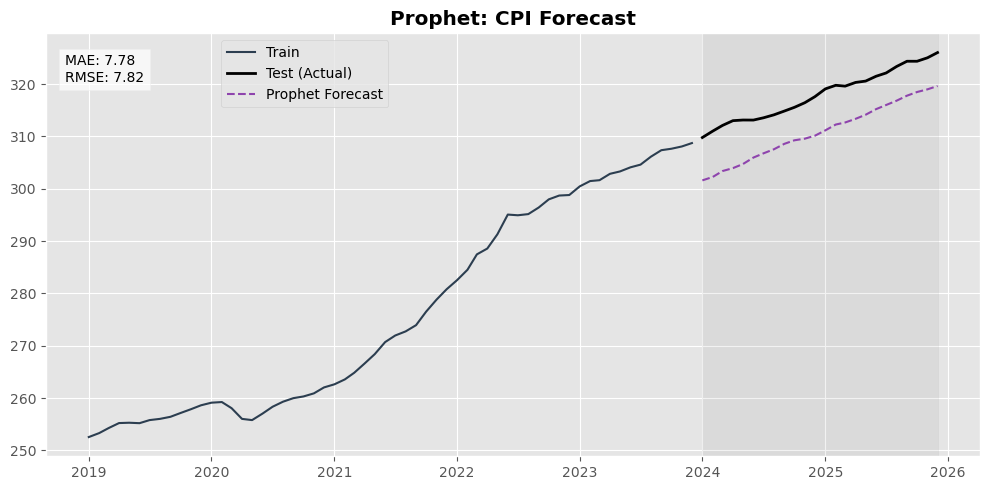

In [29]:
# Plot Comparison
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot data
ax.plot(train.index[-60:], train["y"][-60:], label="Train", color="#2c3e50")
ax.plot(test.index, test["y"], label="Test (Actual)", color="black", linewidth=2)
ax.plot(prophet_forecast.index, prophet_forecast, label="Prophet Forecast", color="#8e44ad", linestyle="--")

# Highlights & Text
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1)
ax.text(0.02, 0.95, "MAE: 7.78\nRMSE: 7.82", transform=ax.transAxes, 
        va='top', bbox=dict(facecolor='white', alpha=0.7))

# Legend & Title
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0))
ax.set_title("Prophet: CPI Forecast", fontweight='bold')

plt.tight_layout()
plt.show()

In [30]:
# Add prophet to results table
results.loc[len(results)] = [
    "Prophet",
    float(prophet_mae),
    float(prophet_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]
results.sort_values("rmse") # sort by rmse

,model,mae,rmse,train_end,test_start,test_end
1,Prophet,7.089454,7.150114,2023-12-01,2024-01-01,2025-12-01
0,"ARIMA(1,1,1)",8.040418,9.286290,2023-12-01,2024-01-01,2025-12-01


In [31]:
## LSTM

In [32]:
# build supervised window
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

LOOKBACK = 24  # 24 months history -> next month

# Fit scaler on TRAIN ONLY to avoid leakage
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[["y"]]).astype(np.float32)
test_scaled  = scaler.transform(test[["y"]]).astype(np.float32)

# For test windows, we need the last LOOKBACK points of train + all test
full_scaled = np.vstack([train_scaled, test_scaled]).astype(np.float32)

def make_windows(series_2d, lookback, start_idx, end_idx):
    # series_2d shape: (N, 1)
    X, y = [], []
    for i in range(start_idx, end_idx):
        X.append(series_2d[i-lookback:i, 0])
        y.append(series_2d[i, 0])
    X = np.array(X, dtype=np.float32)[..., None]  # (samples, lookback, 1)
    y = np.array(y, dtype=np.float32)             # (samples,)
    return X, y

# Train windows: indices within train_scaled
X_train, y_train = make_windows(train_scaled, LOOKBACK, LOOKBACK, len(train_scaled))

# Test windows: predict each test point using preceding LOOKBACK points (includes tail of train)
test_start_in_full = len(train_scaled)  # first test point position in full_scaled
X_test, y_test = make_windows(full_scaled, LOOKBACK, test_start_in_full, len(full_scaled))

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (384, 24, 1) y_train: (384,)
X_test : (24, 24, 1) y_test : (24,)


In [36]:
# Define and train LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    # Reduced L2 penalty from 0.01 to 0.001 to let the model learn more
    layers.LSTM(24, 
                recurrent_dropout=0.1, 
                kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.1),
    # Increased units slightly for better capacity
    layers.Dense(8, activation="relu"), 
    layers.Dense(1)
])

# Returned to standard learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=6, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1515 - val_loss: 0.1892 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0231 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0079 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0077 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0047 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0048 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 10/2

In [37]:
# Predict and Invert scaling back to CPI units
pred_scaled = model.predict(X_test).reshape(-1, 1)

pred = scaler.inverse_transform(pred_scaled).reshape(-1)
actual = test["y"].to_numpy()

lstm_forecast = pd.Series(pred, index=test.index)

lstm_forecast.head(), lstm_forecast.tail()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


(DATE
 2024-01-01    309.121948
 2024-02-01    309.963837
 2024-03-01    310.856384
 2024-04-01    311.770966
 2024-05-01    312.684967
 Freq: MS, dtype: float32,
 DATE
 2025-08-01    323.170013
 2025-09-01    323.911560
 2025-10-01    324.686035
 2025-11-01    325.349457
 2025-12-01    326.018005
 Freq: MS, dtype: float32)

In [40]:
# Validation LSTM Results
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Reverse the scaling
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(model.predict(X_test))

# 2. Calculate Final Real-World Metrics
final_mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
final_rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"Final CPI MAE: {final_mae:.3f}")
print(f"Final CPI RMSE: {final_rmse:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Final CPI MAE: 0.526
Final CPI RMSE: 0.619


In [41]:
# Evaluate LSTM vs Prior models
lstm_mae, lstm_rmse = evaluate_forecast(
    actual,
    lstm_forecast.to_numpy(),
    label="LSTM"
)

LSTM MAE : 0.526
LSTM RMSE: 0.619


In [42]:
# Add to results table + view ranking
results.loc[len(results)] = [
    "LSTM(lookback=24)",
    float(lstm_mae),
    float(lstm_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]

results.sort_values("rmse").reset_index(drop=True)

,model,mae,rmse,train_end,test_start,test_end
0,LSTM(lookback=24),0.526161,0.619408,2023-12-01,2024-01-01,2025-12-01
1,Prophet,7.089454,7.150114,2023-12-01,2024-01-01,2025-12-01
2,"ARIMA(1,1,1)",8.040418,9.286290,2023-12-01,2024-01-01,2025-12-01


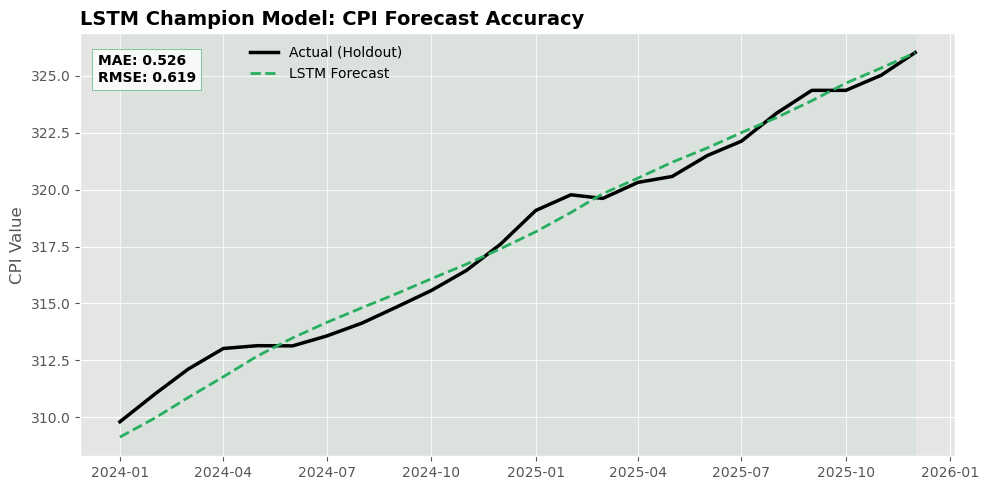

In [46]:
# Plot test vs LSTM Forecast
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Actuals vs LSTM Forecast
ax.plot(test.index, test["y"], label="Actual (Holdout)", color="black", linewidth=2.5)
ax.plot(lstm_forecast.index, lstm_forecast, label="LSTM Forecast", color="#27ae60", linestyle="--", linewidth=2)

# Highlight the Forecast Zone
ax.axvspan(test.index[0], test.index[-1], color='#27ae60', alpha=0.05)

# Add the Metrics Box
stats_text = f"MAE: 0.526\nRMSE: 0.619"
ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
        va='top', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='#27ae60'))

# Titles and Legend
ax.set_title("LSTM Champion Model: CPI Forecast Accuracy", fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0), frameon=False)
ax.set_ylabel("CPI Value")

plt.tight_layout()
plt.show()

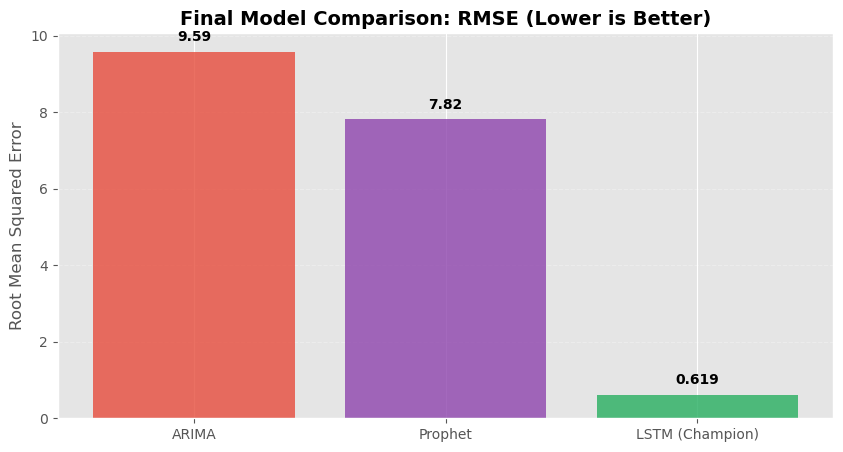

In [47]:
# Model Comparison
import matplotlib.pyplot as plt

models = ['ARIMA', 'Prophet', 'LSTM (Champion)']
rmse_values = [9.59, 7.82, 0.619]
colors = ['#e74c3c', '#8e44ad', '#27ae60']

plt.figure(figsize=(10, 5))
bars = plt.bar(models, rmse_values, color=colors, alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, yval, ha='center', va='bottom', fontweight='bold')

plt.title('Final Model Comparison: RMSE (Lower scores are Better)', fontsize=14, fontweight='bold')
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [48]:
# 
import os
import tensorflow as tf

# 1. Setup Directory for the LSTM model
MODEL_DIR = "model_artifacts/lstm"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "cpi_lstm_model.keras")

# 2. Save using the Keras native format
model.save(MODEL_PATH)

# 3. Confirmation Checks
print(f"Winner Saved to: {MODEL_PATH}")
print(f"File Size: {os.path.getsize(MODEL_PATH) / 1024:.2f} KB")

Winner Saved to: model_artifacts/lstm/cpi_lstm_model.keras
File Size: 62.30 KB


In [49]:
# Define a small local prediction helper
import numpy as np
import pandas as pd

def lstm_predict(model, scaler, input_data):
    """
    Helper to prepare data and return un-scaled predictions.
    input_data: The X_test array (pre-formatted with LOOKBACK)
    """
    # 1. Generate scaled predictions
    preds_scaled = model.predict(input_data, verbose=0)
    
    # 2. Inverse scale back to real CPI units
    preds_unscaled = scaler.inverse_transform(preds_scaled).reshape(-1)
    
    return preds_unscaled

# Test it on your holdout data
local_pred_values = lstm_predict(model, scaler, X_test)

# Display as a clean Series with dates
local_results = pd.Series(local_pred_values, index=test.index)
print(local_results.head())

DATE
2024-01-01    309.121948
2024-02-01    309.963837
2024-03-01    310.856384
2024-04-01    311.770966
2024-05-01    312.684967
Freq: MS, dtype: float32


In [50]:
# Package model & Scaler
import tarfile
import os
import joblib

# 1. Save the scaler (Crucial for the SageMaker endpoint)
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")
joblib.dump(scaler, SCALER_PATH)

# 2. Package both Model and Scaler into the tarball
TARBALL_PATH = "lstm-model.tar.gz"

with tarfile.open(TARBALL_PATH, "w:gz") as tar:
    # Add the keras model
    tar.add(MODEL_PATH, arcname="cpi_lstm_model.keras")
    # Add the scaler
    tar.add(SCALER_PATH, arcname="scaler.pkl")

print(f"Created Champion Tarball: {TARBALL_PATH}")
print(f"Final Package Size: {os.path.getsize(TARBALL_PATH) / 1024:.2f} KB")

Created Champion Tarball: lstm-model.tar.gz
Final Package Size: 34.39 KB
